In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import time
import numpy as np
import xarray as xr
import time
import numpy as np
import cartopy.crs as ccrs
import cartopy as cart
import xclim as xc
import os
from memory_profiler import profile

from matplotlib.colors import BoundaryNorm
import matplotlib.ticker as mticker
import matplotlib.colors as mplcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean as cmo

import matplotlib.gridspec as gridspec
# own functions
import Plot.plotfunctions as plotfunc
import Calculation.humiditycalculation as humidcalc
import Calculation.trend_func as trends
import Calculation.save_detrend_deseason as sdd
import Calculation.heat_wave_indetification as hwi
import Calculation.mask_creation as mc
homefolder = '/home/nniebaum/data_nils'
datafolder = '/data/user/nniebaum'
plotfolder = '/home/nniebaum/bachlor-thesis-code/Plots/'
areafolder = plotfolder + "Area/"
citiesfolder = plotfolder + "Cities/"

rcParams_area = {
                'figure.titlesize': 'x-large',
                'axes.titlesize': 'x-large',
                'axes.labelsize': 'x-large',
                'xtick.labelsize': 'large',
                'ytick.labelsize': 'large',
                'hatch.linewidth' : 1.5,
                'hatch.color' : [0.4,0.4,0.4],
                'figure.facecolor':'w',
                'savefig.bbox': 'tight',
                'savefig.dpi': 400,
                'savefig.facecolor': 'w',
                'savefig.format': 'png',
                'savefig.pad_inches': 0.01,
                'savefig.transparent': False,
                }

plt.rcParams.update(rcParams_area)


/home/nniebaum/miniconda3/envs/py3_std/lib/python3.7/site-packages/xclim/indices/_multivariate.py:18: UserWarning: xclim.indices.generic has been refactored in xclim v0.21.0 and has moved several functions to 'xclim.indices.stats'. The affected functions are as follows: `fit`, `parametric_quantile`, `fa`, `frequency_analysis`, `get_dist`, `get_lm3_dist`, `_fit_start`, `_lm3_dist_map`. They have been made available here for your convenience. This functionality will change in xclim v0.22.0. Please update your scripts accordingly.
  from .generic import select_resample_op


**Open daily max dataset**

In [3]:
data= xr.open_dataset(datafolder + '/New2_europe_full_daymax_masks_population_1900-01-01_2010-12-31.nc')

duration = data.heatwave_mask_ydrunpctl_98_referenceperiod.attrs['duration']
threshold = data.heatwave_mask_ydrunpctl_98_referenceperiod.attrs['threshold']
quantile = data.heatwave_mask_ydrunpctl_98_referenceperiod.attrs['quantile']

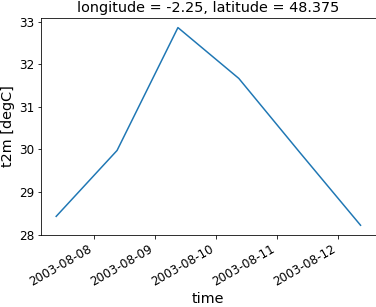

In [4]:
timeslice = slice("2003-01","2003-12")
plot_data = data.t2m.where(data.heatwave_mask_ydrunpctl_98_referenceperiod).sel(time = timeslice).sel(method="nearest", latitude = 48.86, longitude = -2.35)
# plot_data = plot_data.where(data.mask_land).where(plot_data >= duration)
plot_data.plot()#.plot()

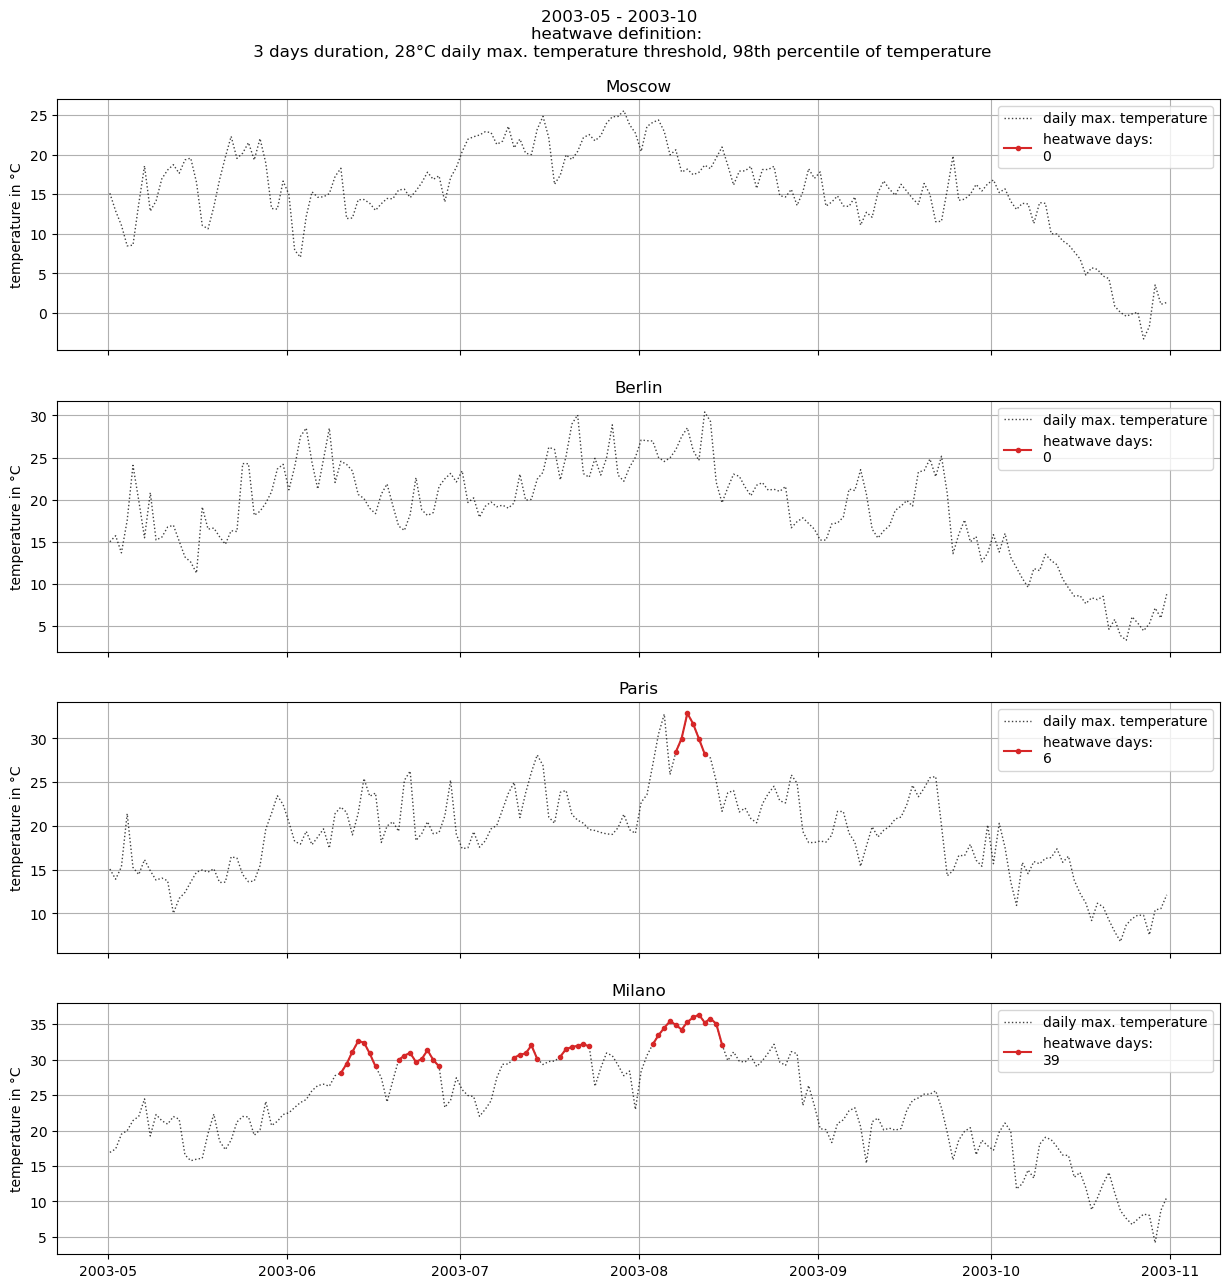

In [6]:
duration = data.heatwave_mask_ydrunpctl_98_referenceperiod.attrs['duration']
threshold = data.heatwave_mask_ydrunpctl_98_referenceperiod.attrs['threshold']
quantile = data.heatwave_mask_ydrunpctl_98_referenceperiod.attrs['quantile']
#create figure title :


timeslice = slice("2003-05", "2003-10")

plt.style.use('default')

groupby = "time.year"

figure_title = timeslice.start + " - " + timeslice.stop + "\nheatwave definition: \n {:.0f} days duration, {:.0f}°C daily max. temperature threshold, {:.0f}th percentile of temperature".format(duration, threshold, quantile*100)

# ========== PLOT ==============
# create the figure and the gridspecs
fig, [ax0,ax1,ax2,ax3] = plt.subplots(nrows = 4, ncols = 1, figsize = (15,15), sharex = True, )
fig.suptitle(figure_title, y = 0.94)

def plot_city(axs, data) :
#     daily_max = data.t2m
    axs.plot(data.time, data.t2m, linestyle = ':', linewidth = 1.0,  color = 'k', alpha = 0.75, label = "daily max. temperature")
#     axs.plot(data.time, data.swbgt, linestyle = ':', linewidth = 1.0,  color = 'tab:blue', alpha = 0.75, label = "daily max. sWBGT")
#     old_heatwavemask= data.t2m.where(data.heatwave_mask_ydrunpctl_98_referenceperiod_25degthreshold)
#     axs.plot(old_heatwavemask.time, old_heatwavemask, linestyle = '-', marker = '.', linewidth = 1.5,  color = 'tab:orange', alpha = 0.75,  label = "heatwave days with 25°C threshold")
    dwd_heatwavemask = data.t2m.where(data.heatwave_mask_ydrunpctl_98_referenceperiod)
    axs.plot(dwd_heatwavemask.time, dwd_heatwavemask, linestyle = '-', marker = '.', linewidth = 1.5, color = 'tab:red', alpha = 1,  label = "heatwave days:\n{}".format(data.heatwave_mask_ydrunpctl_98_referenceperiod.sum().values))


# Moscow
city = lambda ds : ds.sel(method="nearest", latitude = 55.76, longitude = 37.62) 
plot_city(ax0, city(data.sel(time = timeslice)))
ax0.set_title("Moscow")

#Berlin
city = lambda ds : ds.sel(method="nearest", latitude = 52.5, longitude = 13.4) 
plot_city(ax1, city(data.sel(time = timeslice)))
ax1.set_title("Berlin")

# Paris
city = lambda ds : ds.sel(method="nearest", latitude = 48.86, longitude = -2.35)
plot_city(ax2, city(data.sel(time = timeslice)))
ax2.set_title("Paris")

# Mailand 
city = lambda ds : ds.sel(method="nearest", latitude = 45.46, longitude = 9.19)
plot_city(ax3, city(data.sel(time = timeslice)))
ax3.set_title("Milano")

for axs in [ax0,ax1,ax2,ax3]:
    axs.grid('on')
    axs.legend(loc = "upper right")
    axs.set_ylabel('temperature in °C')

    
fig.savefig(citiesfolder + "cities_heatwavedays_{}_{}_ydrunpctl_98_referenceperiod".format(timeslice.start, timeslice.stop))